In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Problem is the classification of solid waste (plastic, glass, cardboard, metal). The solid waste issue arises with the aim of addressing the threats posed by pollution created by a consumption-oriented society to human health and the future. Therefore, recycling waste that can be recycled and reusing it is an effective step in reducing environmental pollution.

In [4]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

While reading the dataset, two variables will need to be maintained. There will be a change in the image dimensions, and we will store the size information in a variable (target_size) for this transformation.

The dataset is unlabeled, and we will label the data simply. We will perform the labeling for each image using the folder names in the uploaded data. What we need are the numerically encoded versions of the labels. Therefore, we are creating a dictionary to map class names to numbers.

In [5]:
target_size = (224, 224)

waste_labels ={'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [6]:
data_dir =  '/content/drive/MyDrive/Garbage classification'

In [7]:
# dataset loading function
def load_dataset(path, target_size, waste_labels):

    x = []       # keeps matrix information of images
    labels = []  # keeps the class information to which the image belongs

    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        img = cv2.imread(image_path)

        # the images read will be rescaled according to the initially given target_size
        img = cv2.resize(img, target_size)

        x.append(img)

        # when each path is split by the '/' character, the last two elements of the resulting list represent the label.
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])

    # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state=42)

    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels

In [8]:
x, labels = load_dataset(data_dir,target_size, waste_labels)

X boyutu: (2537, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2537


In [9]:
# Retaining Image Dimensions
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
input_shape

(224, 224, 3)

In [10]:
# Displaying Examples from the Dataset
def visualize_img(image_batch, label_batch):

  # image_batch: Holds the matrix information for the images.
  # label_batch: Contains a list of class information to which the image belongs.

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n] == 1][0].title())
    plt.axis('off')

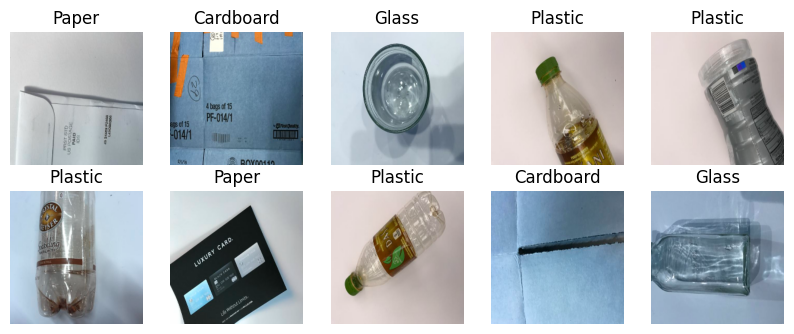

In [11]:
visualize_img(x, labels)

The function of the ImageDataGenerator is to generate data. It enables the creation of a rich and diverse dataset from a small dataset for many tasks, such as image recognition, object classification, or image segmentation.
It performs this process using techniques such as cropping, flipping, padding, and adding noise, thereby increasing the amount of data.
The data in our dataset consists of images taken under white light. These images need to be diversified to resemble real-life scenarios.

In [12]:
# data preparation
# we define a generator for the training dataset.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# we define a generator for the test dataset.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

We have not yet split the data into test and train sets, so there’s no need to be confused. What we are doing right now is defining the operations we will perform once we split the data into test and train sets.

In [13]:
# the flow_from_directory function is a method used to bring images into the TensorFlow environment.
train_generator = train.flow_from_directory(directory=data_dir,
                                            target_size=(target_size),
                                            class_mode='categorical',
                                            subset='training')

test_generator = test.flow_from_directory(directory=data_dir,
                                          target_size=(target_size),
                                          batch_size=251,
                                          class_mode='categorical',
                                          subset='validation')

Found 2285 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


The layers we will use when creating the model are as follows:

* Sequential
* Convolution Layer (Conv2D)
* Pooling Layer
* Activation Layer
* Flattening Layer
* Dense Layer
* Dropout Layer


The appropriate layer configurations are actually hyperparameters. We need to choose the ones that best suit the model. We can perform an example modeling like this.

In [14]:
# modeling
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# setting optimization and evaluation metrics
model.compile(loss='categorical_crossentropy',    # since there are multiple classes, we used categorical_crossentropy (if there were two classes, binary_crossentropy would be used).
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [17]:
# if there is no progress in validation, it means overfitting has started.
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]
             # we use the ModelCheckpoint function to save the best model captured during the iterations of the model.

Workers refer to the number of threads that create batches in parallel (the batches are calculated in parallel on the CPU and are immediately transferred to the GPU for neural network computations). It is a hardware-related parameter.

Steps_per_epoch refer to the total number of steps to complete before signaling that an epoch is finished and the next epoch begins.

In [19]:
# training the model
history = model.fit(x = train_generator,
                    epochs=100,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2285//32,
                    validation_steps=252//32)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - acc: 0.1847 - loss: 1.8357 - precision: 0.1009 - recall: 0.0035
Epoch 1: val_loss improved from inf to 1.64605, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 64s 689ms/step - acc: 0.1849 - loss: 1.8347 - precision: 0.1025 - recall: 0.0035 - val_acc: 0.3214 - val_loss: 1.6460 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 2/100
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.1875 - loss: 1.5981 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 1.64605
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.1875 - loss: 1.5981 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.2540 - val_loss: 1.7017 - val_precision: 1.0000 - val_recall: 0.0079
Epoch 3/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - acc: 0.2915 - loss: 1.6313 - precision: 0.4959 - recall: 0.0334
Epoch 3: val_loss improved from 1.64605 to 1.59773, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step -

Due to the absence of early stopping and as can be seen from the resulting accuracy values, improvements can be made in the model's hyperparameters; for example, we could have increased the number of epochs further.

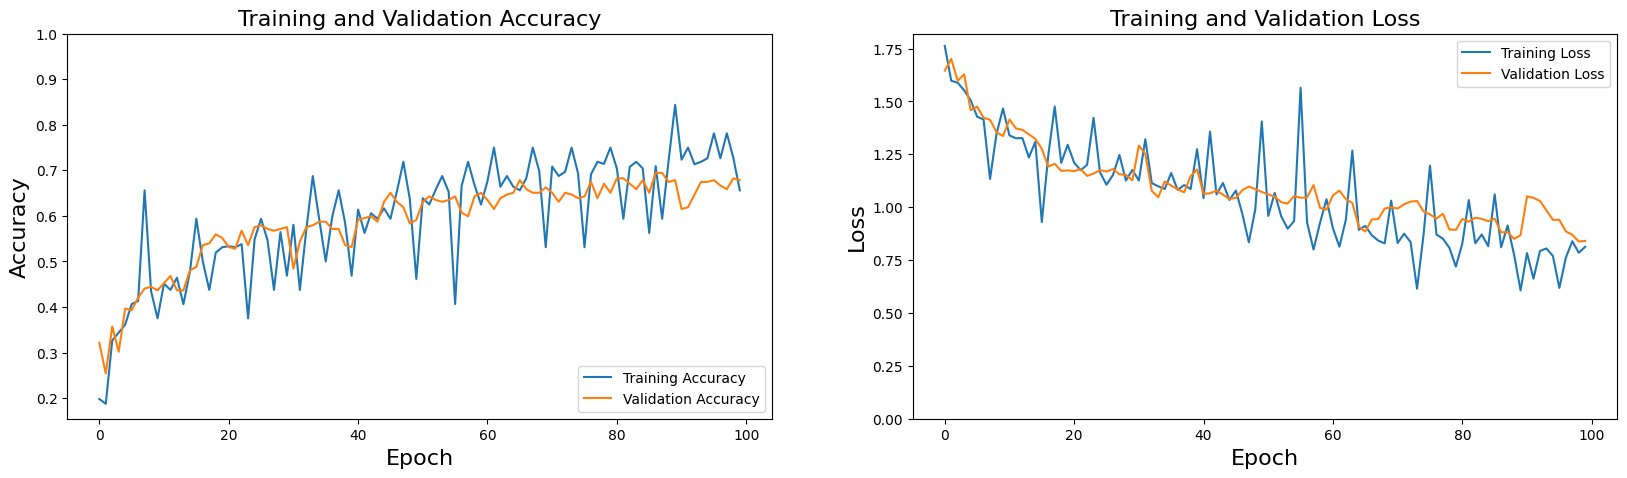

In [20]:
# Accuracy and Loss Graphs

# Accuracy Graph #
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# Loss Graph #
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

As can be seen from the graphs, increasing the number of epochs might be a good option.

In [21]:
# evaluation
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.6781 - loss: 0.8414 - precision: 0.7911 - recall: 0.5868


In [22]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6781 - loss: 0.8419 - precision: 0.7911 - recall: 0.5868

Test accuracy: 67.9%

Test loss: 84.1%

Test precision: 79.1%

Test recall: 58.7%


To summarize briefly:
* Accuracy: The rate of correct classification.
* Loss: A metric from an optimization perspective, where lower is better.
* Precision: A metric showing how successful the predictions are.
* Recall: A metric indicating how accurately we predict the actual classes

To query the model with the test dataset, we need pixel and actual values. We will use the next function to obtain x_test and y_test.

In [24]:
# Classification Report
x_test, y_test = next(test_generator)

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step


There might be some confusion about whether we just performed error evaluation. Previously, we observed the error based on the outputs of the model object. Now, we will use this model to query the test set and ask it to predict the labels. Based on the predictions, we will create a classification report.

The reason for taking the maximum in y_pred is to understand which class the predicted image will belong to.

In [25]:
target_names = list(waste_labels.keys())  # let's access the names of the classes for the dependent variable.

In [26]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.83      0.62      0.71        40
       glass       0.66      0.76      0.70        50
       metal       0.53      0.71      0.61        42
       paper       0.79      0.95      0.86        59
     plastic       0.70      0.33      0.45        48
       trash       0.50      0.50      0.50        12

    accuracy                           0.68       251
   macro avg       0.67      0.65      0.64       251
weighted avg       0.69      0.68      0.67       251



The success metrics for each class are displayed separately.

We can also use a confusion matrix as another performance evaluation metric.

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontweight="bold")
    plt.xlabel('Predicted label', fontweight="bold")

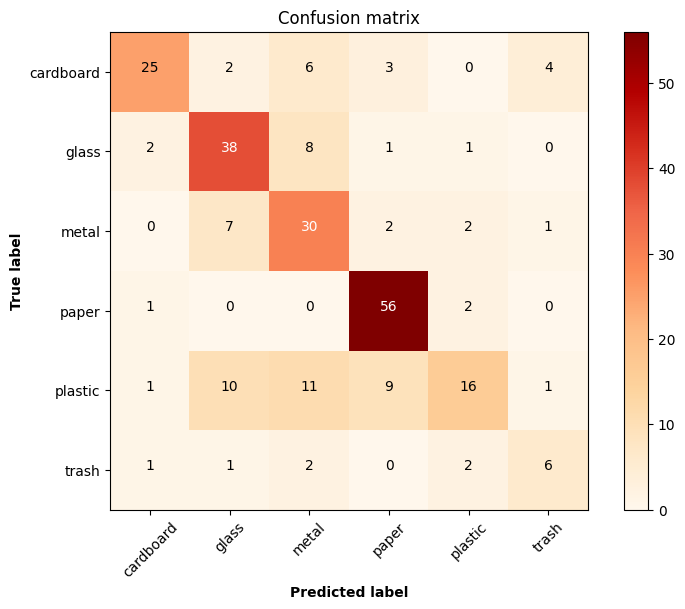

In [28]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)

The confusion matrix is a metric we can use when we want to visualize the mathematical output results.